<a href="https://colab.research.google.com/github/harrynguyen14/Corp_analysis/blob/main/BWE_StockPredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from math import sqrt

import warnings
warnings.filterwarnings('ignore')
#

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/BWE/BWE.csv')
df.head()

,Ngày,Lần cuối,Mở,Cao,Thấp,KL,% Thay đổi
0,20/09/2024,"47,000.0","47,500.0","47,500.0","46,600.0",205.00K,-0.11%
1,19/09/2024,"47,050.0","45,000.0","47,050.0","45,000.0",878.50K,4.79%
2,18/09/2024,"44,900.0","45,200.0","45,700.0","44,900.0",123.10K,-0.66%
3,17/09/2024,"45,200.0","45,600.0","45,600.0","44,900.0",312.90K,-0.88%
4,16/09/2024,"45,600.0","46,300.0","46,300.0","45,400.0",276.00K,-1.08%


In [ ]:
df.drop(['KL', '% Thay đổi'],axis=1,inplace=True)

In [ ]:
df.rename(columns={'Ngày':'Date','Mở':'Open','Lần cuối':'Price','Cao':'High','Thấp':'Low'},inplace=True)
df.head()

,Date,Price,Open,High,Low
0,20/09/2024,"47,000.0","47,500.0","47,500.0","46,600.0"
1,19/09/2024,"47,050.0","45,000.0","47,050.0","45,000.0"
2,18/09/2024,"44,900.0","45,200.0","45,700.0","44,900.0"
3,17/09/2024,"45,200.0","45,600.0","45,600.0","44,900.0"
4,16/09/2024,"45,600.0","46,300.0","46,300.0","45,400.0"


In [ ]:
df["Date"] = pd.to_datetime(df["Date"], format='%d/%m/%Y' ,errors='coerce')
df.head()

,Date,Price,Open,High,Low
0,2024-09-20,"47,000.0","47,500.0","47,500.0","46,600.0"
1,2024-09-19,"47,050.0","45,000.0","47,050.0","45,000.0"
2,2024-09-18,"44,900.0","45,200.0","45,700.0","44,900.0"
3,2024-09-17,"45,200.0","45,600.0","45,600.0","44,900.0"
4,2024-09-16,"45,600.0","46,300.0","46,300.0","45,400.0"


In [ ]:
df.shape

(1415, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1415 entries, 0 to 1414
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1415 non-null   datetime64[ns]
 1   Price   1415 non-null   object        
 2   Open    1415 non-null   object        
 3   High    1415 non-null   object        
 4   Low     1415 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 55.4+ KB


In [ ]:
df.describe()

,Date
count,1415
mean,2021-11-21 05:44:59.363957504
min,2019-01-21 00:00:00
25%,2020-06-24 12:00:00
50%,2021-11-18 00:00:00
75%,2023-04-20 12:00:00
max,2024-09-20 00:00:00


In [ ]:
from matplotlib.dates import YearLocator, DateFormatter, MonthLocator

df = df.sort_values(by='Date')

# Chuyển đổi định dạng các cột giá thành số thực
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Open'] = df['Open'].str.replace(',', '').astype(float)
df['High'] = df['High'].str.replace(',', '').astype(float)
df['Low'] = df['Low'].str.replace(',', '').astype(float)

# Lấy thông tin năm từ cột "Ngày"
df['Year'] = df['Date'].dt.year

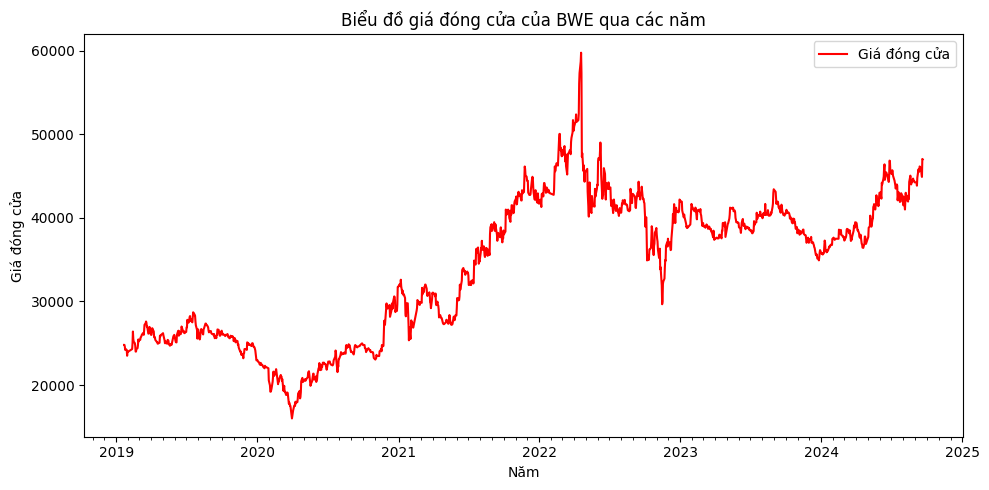

In [ ]:
# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Price'], label='Giá đóng cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của BWE qua các năm')
plt.legend(loc='best')

# Định dạng đồ thị hiển thị các ngày tháng theo năm-tháng
years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()  # Thêm dòng này để khai báo MonthLocator
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

plt.tight_layout()
plt.show()

In [ ]:
df1 = pd.DataFrame(df,columns=['Date','Price'])
df1.index = df1.Date
df1.drop('Date',axis=1,inplace=True)
df1

,Price
Date,
2019-01-21,24800.0
2019-01-22,24800.0
2019-01-23,24600.0
2019-01-24,24200.0
2019-01-25,24300.0
...,...
2024-09-16,45600.0
2024-09-17,45200.0
2024-09-18,44900.0


##LSTM

In [ ]:
data = df1.values
train_data = data[:1000]
test_data = data[1000:]

In [ ]:
data

array([[24800.],
       [24800.],
       [24600.],
       ...,
       [44900.],
       [47050.],
       [47000.]])

In [ ]:
da = MinMaxScaler(feature_range=(0,1))
da_train = da.fit_transform(train_data)

In [ ]:
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(da_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(da_train[i,0]) #lấy ra giá đóng cửa ngày hôm sau

In [ ]:
x_train

[array([0.2010877 , 0.2010877 , 0.19651753, 0.18737718, 0.18966226,
        0.18737718, 0.17138156, 0.182807  , 0.18166446, 0.182807  ,
        0.18966226, 0.20565788, 0.2376491 , 0.21708331, 0.21022805,
        0.20565788, 0.19880261, 0.182807  , 0.182807  , 0.18966226,
        0.19194735, 0.19994516, 0.21594077, 0.21022805, 0.21479823,
        0.21479823, 0.22165349, 0.22279603, 0.22508112, 0.22850875,
        0.23307893, 0.23079384, 0.22850875, 0.23993419, 0.2559298 ,
        0.26049998, 0.26507015, 0.26164252, 0.25135963, 0.25135963,
        0.23193638, 0.23193638, 0.23536401, 0.25021708, 0.24450436,
        0.22850875, 0.22850875, 0.23879165, 0.24678945, 0.24450436]),
 array([0.2010877 , 0.19651753, 0.18737718, 0.18966226, 0.18737718,
        0.17138156, 0.182807  , 0.18166446, 0.182807  , 0.18966226,
        0.20565788, 0.2376491 , 0.21708331, 0.21022805, 0.20565788,
        0.19880261, 0.182807  , 0.182807  , 0.18966226, 0.19194735,
        0.19994516, 0.21594077, 0.21022805, 0.

In [ ]:
#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [ ]:
# #xây dựng mô hình
# model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào
# #2 lớp LSTM
# model.add(LSTM(units=128,input_shape=(x_train.shape[1],1),return_sequences=True))
# model.add(LSTM(units=64))
# model.add(Dropout(0.5)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)
# model.add(Dense(1)) #output đầu ra 1 chiều
# #đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
# model.compile(loss='mean_absolute_error',optimizer='adam')

In [ ]:
# from keras.callbacks import ModelCheckpoint

# save_model = "/content/drive/MyDrive/BWE/save_model2.keras" # Changed the extension to .keras
# best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
# model.fit(x_train,y_train,epochs=100,batch_size=50,verbose=2,callbacks=[best_model])

In [ ]:
#dữ liệu train
y_train = da.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/BWE/save_model2.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = da.inverse_transform(y_train_predict) #giá dự đoán

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step


In [ ]:
y_train_predict

array([[27162.672],
       [27038.791],
       [26633.932],
       [26511.729],
       [26533.28 ],
       [26445.707],
       [26265.107],
       [26135.096],
       [25933.34 ],
       [25782.145],
       [25722.234],
       [25666.797],
       [25999.34 ],
       [26071.49 ],
       [26089.715],
       [26200.727],
       [26179.807],
       [25968.91 ],
       [25833.4  ],
       [25938.402],
       [26133.64 ],
       [26079.027],
       [25885.93 ],
       [25873.18 ],
       [25739.723],
       [25624.932],
       [25421.662],
       [25325.244],
       [25496.35 ],
       [25655.51 ],
       [25700.082],
       [25586.902],
       [25715.393],
       [25826.746],
       [25895.857],
       [25899.934],
       [26006.768],
       [25853.217],
       [25800.215],
       [25895.17 ],
       [26017.686],
       [26456.725],
       [26729.924],
       [26638.67 ],
       [26155.783],
       [26188.295],
       [26247.244],
       [26475.98 ],
       [26833.027],
       [27316.64 ],


In [ ]:
#xử lý dữ liệu test
test = df1[len(train_data)-50:].values
test = test.reshape(-1,1)
sc_test = da.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1000:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = da.inverse_transform(y_test_predict) #giá dự đoán

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [ ]:
#lập biểu đồ so sánh
train_data1 = df1[50:1000]
test_data1 = df1[1000:]

print(f"Length of y_test_predict: {len(y_test_predict)}")
print(f"Length of test_data1: {len(test_data1)}")

Length of y_test_predict: 415
Length of test_data1: 415


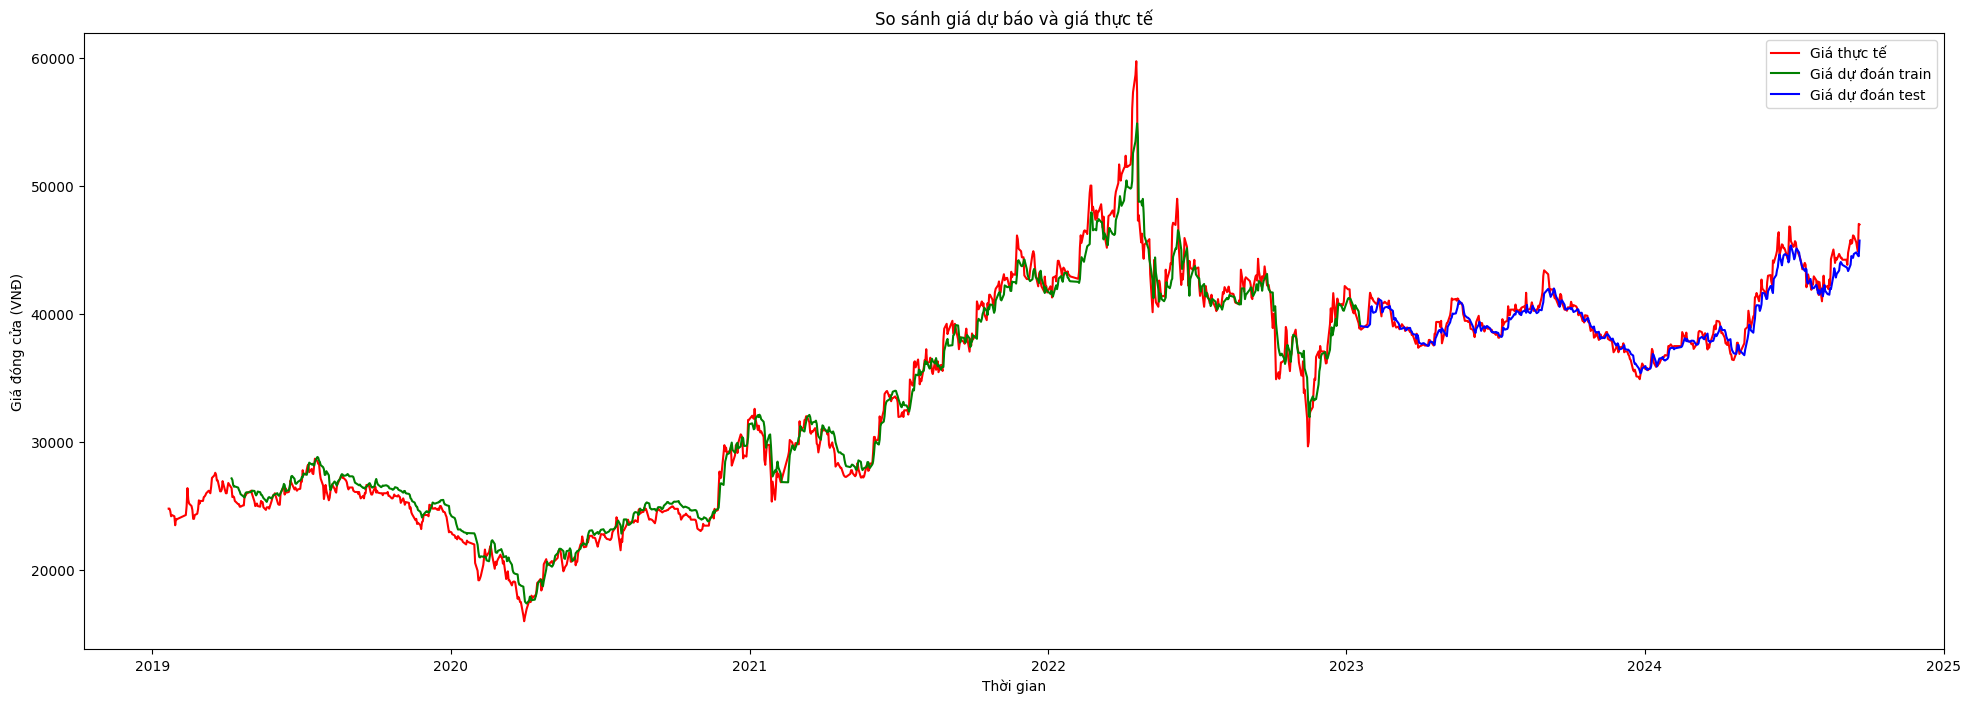

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(df1,label='Giá thực tế',color='red') #đường giá thực

train_data1['Dự đoán'] = y_train_predict[:len(train_data1)] #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train

test_data1 = test_data1[:len(y_test_predict)]
test_data1['Dự đoán'] = y_test_predict.flatten()
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

In [ ]:
#r2
print('Độ phù hợp tập train:',r2_score(y_train,y_train_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập train (VNĐ):',mean_absolute_error(y_train,y_train_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập train:',mean_absolute_percentage_error(y_train,y_train_predict))

Độ phù hợp tập train: 0.9840322862380476
Sai số tuyệt đối trung bình trên tập train (VNĐ): 821.4276254111841
Phần trăm sai số tuyệt đối trung bình tập train: 0.02612721736822539


In [ ]:
train_data1

,Price,Dự đoán
Date,,
2019-04-08,26400.0,27162.671875
2019-04-09,25700.0,27038.791016
2019-04-10,25750.0,26633.931641
2019-04-11,25700.0,26511.728516
2019-04-12,25400.0,26533.279297
...,...,...
2023-01-12,40063.0,40694.824219
2023-01-13,39892.0,40547.320312
2023-01-16,39296.0,40222.265625


In [ ]:
print(f"Length of y_test: {len(y_test)}")

Length of y_test: 415


In [ ]:
print(f"Shape of test array: {test.shape}")

Shape of test array: (465, 1)


In [ ]:
#r2
print('Độ phù hợp tập test:',r2_score(y_test,y_test_predict))
#mae
print('Sai số tuyệt đối trung bình trên tập test (VNĐ):',mean_absolute_error(y_test,y_test_predict))
#mae
print('Phần trăm sai số tuyệt đối trung bình tập test:',mean_absolute_percentage_error(y_test,y_test_predict))

Độ phù hợp tập test: 0.9254091305690485
Sai số tuyệt đối trung bình trên tập test (VNĐ): 516.4212914156626
Phần trăm sai số tuyệt đối trung bình tập test: 0.012629600780381058


In [ ]:
test_data1

,Price,Dự đoán
Date,,
2023-01-19,38784.0,39057.347656
2023-01-27,39211.0,38987.335938
2023-01-30,41667.0,39203.644531
2023-01-31,41491.0,40508.871094
2023-02-01,41228.0,40614.558594
...,...,...
2024-09-16,45600.0,44827.210938
2024-09-17,45200.0,44699.257812
2024-09-18,44900.0,44582.582031


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


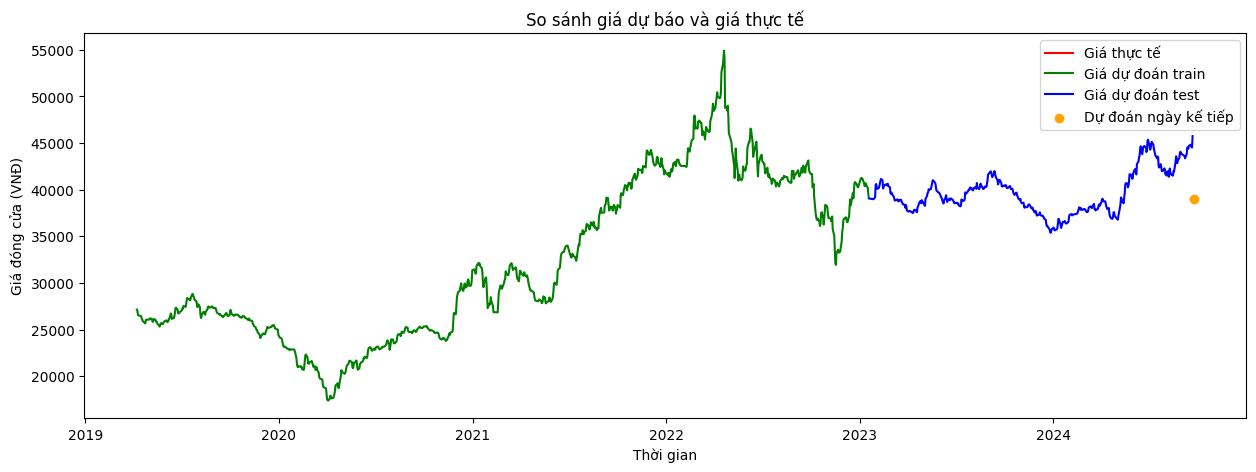

In [ ]:
# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = df['Date'].iloc[-1] + pd.Timedelta(days=2)

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

# Lấy giá trị của ngày cuối cùng trong tập dữ liệu
next_closing_price = np.array([df['Price'].iloc[-1]])  # Lấy giá trị đóng cửa của ngày cuối cùng

# Chuẩn hóa giá trị của ngày cuối cùng
next_closing_price_normalized = da.transform(next_closing_price.reshape(-1, 1))  # Chuyển thành mảng 2D

# Tạo dự đoán cho ngày kế tiếp bằng mô hình đã huấn luyện
x_next = np.array([da_train[-50:, 0]])  # Lấy 50 giá đóng cửa gần nhất
x_next = np.reshape(x_next, (x_next.shape[0], x_next.shape[1], 1))
y_next_predict = final_model.predict(x_next)
y_next_predict = da.inverse_transform(y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
df_next = pd.DataFrame({'Date': [next_date], 'Price': [y_next_predict[0][0]]})
df1 = pd.concat([df1, df_next])

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(df1['Date'], df1['Price'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.scatter([next_date], [y_next_predict[0][0]], color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()


In [ ]:
# # Lấy giá trị của ngày cuối cùng trong tập dữ liệu
# actual_closing_price = df['Price'].iloc[-1]

# # Tạo DataFrame so sánh giá dự đoán với giá ngày cuối trong tập dữ liệu
# comparison_df = pd.DataFrame({'Ngày': [next_date], 'Giá dự đoán': [y_next_predict[0][0]], 'Giá ngày trước': [actual_closing_price]})

# # In ra bảng so sánh
# print(comparison_df)